In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


### 2. Load and Inspect Data

- there is no missing value
- data has huge gap -> need to rescale

In [5]:
df = pd.read_csv("Wholesale customers data.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicatessen      440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [44]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,CustomerID,Cluster,Total_Spending
0,2,3,12669,9656,7561,214,2674,1338,0,2,34112
1,2,3,7057,9810,9568,1762,3293,1776,1,2,33266
2,2,3,6353,8808,7684,2405,3516,7844,2,2,36610
3,1,3,13265,1196,4221,6404,507,1788,3,2,27381
4,2,3,22615,5410,7198,3915,1777,5185,4,2,46100


In [8]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### 3. Feature Engineering
- Create `CustomerID` for traceability
- Compute total annual spending across all product categories

In [ ]:
df['CustomerID'] = df.index
df['Total_Spending'] = df.iloc[:, 2:].sum(axis=1)

### 4. Feature Selection and Scaling
- Select the six numeric product features
- Applies standardlization to give equal weight to each feature before clustering

In [ ]:
features = df.columns[2:8].to_list()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)

### 5. K Evaluation: Elbow & Silhouette
- Inertia (SSE): Measures cluster compactness
- Silhouette Score: Measures separation between clusters

In [58]:
K_range = range(2, 11)
inertia = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_) #SSE
    silhouette_scores.append(silhouette_score(scaled_df,kmeans.labels_))

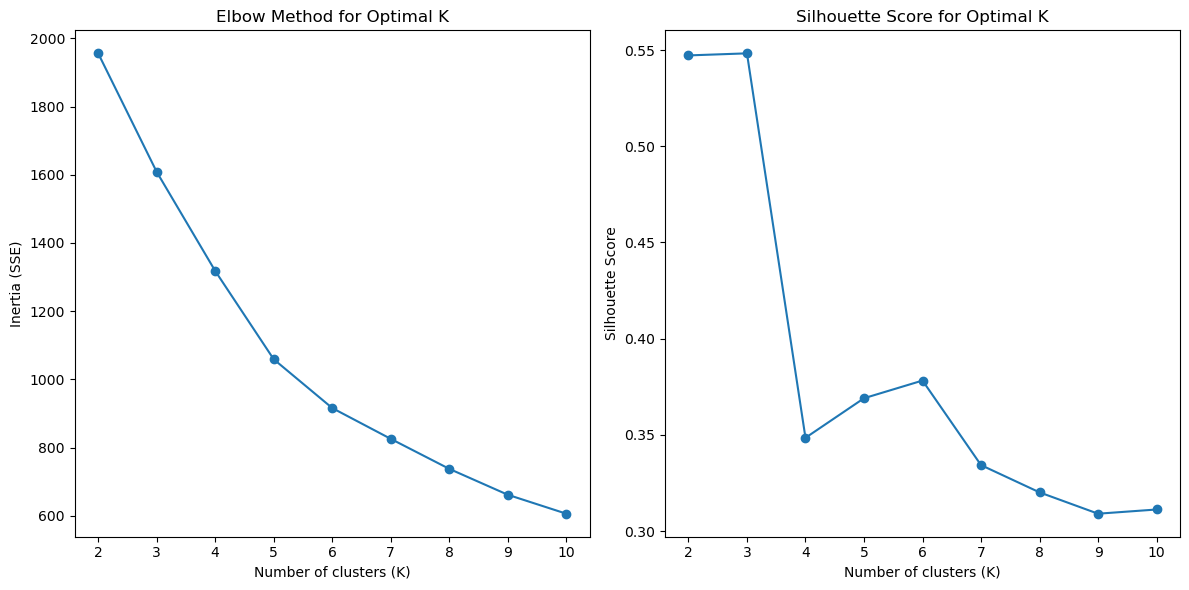

In [59]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia (SSE)')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


### 6. KMeans Clustering (K=3)

In [64]:
optimeal_k = 3  # Based on the plots, choose the optimal K
kmeans = KMeans(n_clusters=optimeal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_df)

df['Cluster'] = cluster_labels

In [ ]:
n_counts = df.value_counts('Cluster').sort_index().reset_index()
n_counts.columns = ['Cluster', '#_of_Customers']

channel_map = {1: 'Horeca', 2: 'Retail'}
df['Channel_Name'] = df['Channel'].map(channel_map)

channel_dist = pd.crosstab(df['Cluster'], df['Channel_Name'], normalize='index').round(3)

region_map = {1: 'Lisbon', 2: 'Oporto', 3: 'Other'}
df['Region_Name'] = df['Region'].map(region_map)

region_dist = pd.crosstab(df['Cluster'], df['Region_Name'], normalize='index').round(3)

cluster_means = df.groupby('Cluster')[features + ['Total_Spending']].mean().round(0).astype(int)

cluster_means_pct = pd.DataFrame()
for col in features:
    cluster_means_pct[f'{col}_Ratio'] = (cluster_means[col] / cluster_means['Total_Spending']).round(2)

profile_df = pd.concat([n_counts, channel_dist, region_dist, cluster_means, cluster_means_pct], axis=1)

profile_df.to_csv('customer_segments_profile.csv', index=False)

,Cluster,#_of_Customers
0,0,45
1,1,393
2,2,2


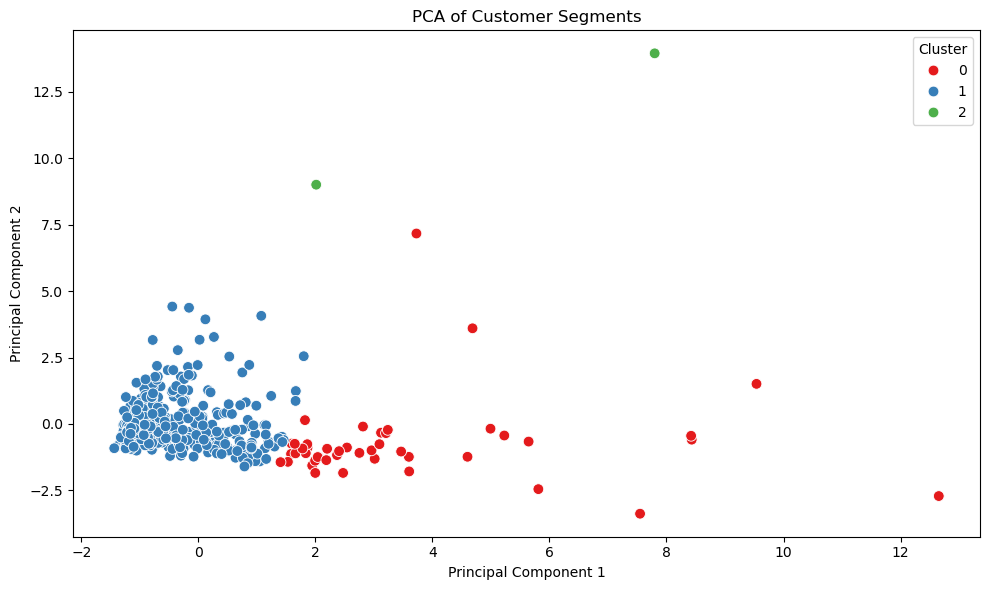

In [76]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_df[features])

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['Cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', s=60)
plt.title('PCA of Customer Segments')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [94]:
print(pca.explained_variance_ratio_)

[0.44082893 0.283764  ]


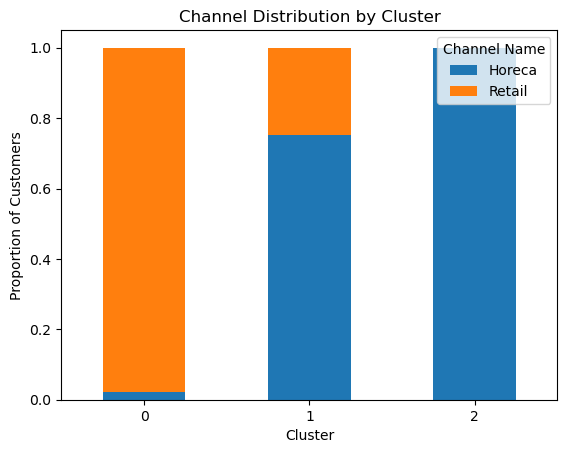

In [91]:
channel_dist.plot(kind='bar', stacked=True)
plt.title('Channel Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Customers')
plt.xticks(rotation=0)
plt.legend(title='Channel Name')
plt.show()

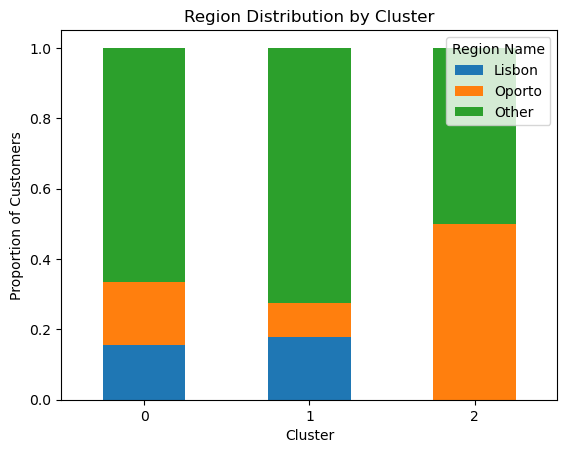

In [92]:
region_dist.plot(kind='bar', stacked=True)
plt.title('Region Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Customers')
plt.xticks(rotation=0)
plt.legend(title='Region Name')
plt.show()